# Introduction

This is a notebook to see if there is an impact of the socio-demographic variables on the tendency for the subject to get `Right` or `Wrong`. 
It also serves as a recoding and cleaning notebook to obtain a clean dataset that can be reused for other analysis in the future. 


## Import modules and functions

### Modules

In [1]:
# Import modules
import json
import csv
import math

import itertools 
from itertools import combinations

In [2]:
# Classic analysis imports
import numpy as np 
import pandas as pd 
import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import seaborn as sns

In [3]:
# Stat analysis import 
from sklearn import preprocessing
from sklearn.cluster import KMeans


import scipy 
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from statsmodels.sandbox.stats.multicomp import multipletests

import scikit_posthocs as sp

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.stattools as stools

import statsmodels.stats as stats 

from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.anova import anova_lm

from statsmodels.stats import multicomp as mc
#from statsmodels.miscmodels.ordinal_model import OrderedModel

import pingouin as pg

#from pymer4.models import Lmer

/home/olivier/.local/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.5.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [4]:
# options for the notebook
pd.set_option('display.max_colwidth',1000)
plt.style.use('seaborn')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = [5, 5]

# Data

## Loading

In [5]:
# Setting up the folders 
data_folder = "../data/"
analysis_results_folder = "../results/"
plots_folders = "../plots"

# Filenames
dataset_filename = 'sondea_analisis_20210323_SONDEA.csv'
dataset_clean_filename = 'cleaned_dataset_per_subject.csv'

dataset_topic_filename = 'news _information _methodology_news.csv'
dataset_news_filename = 'details_news.csv'
dataset_news_full_filename = 'cleaned_dataset_per_news.csv'

In [6]:
# Load the raw dataset
df_raw = pd.read_csv('{}{}'.format(data_folder, dataset_filename),  sep=';')

In [7]:
# Load topic
df_topic = pd.read_csv('{}{}'.format(data_folder, dataset_topic_filename), sep=';')
df_topic = df_topic[['Titulo', 'General Topics ']]
df_topic.columns = ['news_title', 'topic']

In [8]:
# convert to datetime columns to type datetime
df_raw['dt_arrive'] = pd.to_datetime(df_raw['date_arrive'])
df_raw['dt_finish'] = pd.to_datetime(df_raw['date_finish'])

# create a new variable to store time completion (in minutes)
df_raw['time_completion_min'] = df_raw.apply(lambda row: round((row['dt_finish'] - row['dt_arrive']).seconds/60,3), axis=1)

#df_raw['dm_lugar'] = df_raw.apply(lambda row: row['dm_provincia'] if row['dm_provincia'] != 'Fuera de España' else unicodedata.normalize('NFD', row['dm_prov_otro'].strip().title()).encode('ascii', 'ignore').decode(), axis=1)
df_raw['dm_lugar_country'] = df_raw.apply(lambda row: row['dm_prov_otro'] if row['dm_provincia'] == 'Fuera de España' else 'España', axis=1)
#TODO [CCAA]

df_raw['dm_employment'] = df_raw.apply(lambda row: row['dm_empleo'] if row['dm_empleo'] != 'Otro' else row['dm_empleo_otro'].strip().title(), axis=1)


### Recode NS/NC into Np.NaN
It seems the NS/NC is equal to `no answer`. We recoded globally accordingly. The consequence in all further analysis is that people who did not answer the question will be removed from the analysis. They are removed for the analysis they did not provide an answer, not removed from the dataset (therefore we will have different N).

In [9]:
# Replace the NS/NC as np.nan to exclude subject in analysis
df_raw = df_raw.replace('NS/NC', np.nan)

## Filtering

### On survey completion

To decide which data are considered as completed, the time to reach `time_news2` is use and it is 

In [10]:
# #FIXME The date_finish is never None. Therefore that datapoint is not relevant. 
fin = ~df_raw['date_finish'].isnull() # finished experiments
ini = df_raw['time_index']>0          # initiated or read news 1
read_only_1 = ini & (df_raw['time_news1']==0) # read only 1 news
read_both = df_raw['time_news1']>0    # read both news
got_to_ans = df_raw['time_news2']>0    # read both news and got to ans

In [11]:
# Filtering
df_all = df_raw
df_init = df_raw[ini]
df = df_raw[got_to_ans]

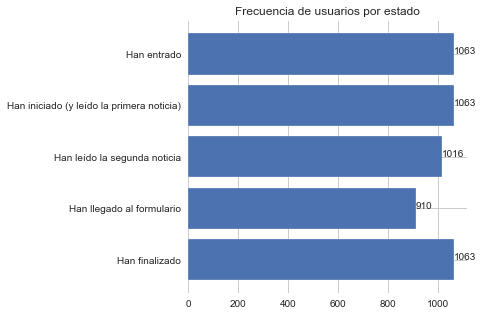

In [12]:
y = ['Han entrado','Han iniciado (y leído la primera noticia)','Han leído la segunda noticia', 'Han llegado al formulario', 'Han finalizado']
x = [df_all.shape[0], df_all[ini].shape[0], df_all[read_both].shape[0], df_all[got_to_ans].shape[0], df_all[fin].shape[0]]
plt.barh(y, x)
for index, value in enumerate(y):
    plt.text(x[index], index, str(x[index]))

plt.gca().invert_yaxis()
plt.title('Frecuencia de usuarios por estado')
plt.show()

The column `Han finalizado` is inconsistent with the other counts. After inspection it is because there is no `None` value for that variable.

In [13]:
df = df_raw[got_to_ans]

print('Size of the filtered sample: {}'.format(df.shape[0]))

Size of the filtered sample: 910


### On time completion

In [14]:
# To put the outliers in the first and last bin
# Source: https://stackoverflow.com/a/51050772
def outlier_aware_hist(data, lower=None, upper=None):
    if not lower or lower < data.min():
        lower = data.min()
        lower_outliers = False
    else:
        lower_outliers = True

    if not upper or upper > data.max():
        upper = data.max()
        upper_outliers = False
    else:
        upper_outliers = True

    n, bins, patches = plt.hist(data, range=(lower, upper), bins='auto')

    if lower_outliers:
        n_lower_outliers = (data < lower).sum()
        patches[0].set_height(patches[0].get_height() + n_lower_outliers)
        patches[0].set_facecolor('c')
        patches[0].set_label('Lower outliers: ({:.2f}, {:.2f})'.format(data.min(), lower))

    if upper_outliers:
        n_upper_outliers = (data > upper).sum()
        patches[-1].set_height(patches[-1].get_height() + n_upper_outliers)
        patches[-1].set_facecolor('m')
        patches[-1].set_label('Upper outliers: ({:.2f}, {:.2f})'.format(upper, data.max()))

    if lower_outliers or upper_outliers:
        plt.legend()

def mad(data):
    median = np.median(data)
    diff = np.abs(data - median)
    mad = np.median(diff)
    return mad

def calculate_bounds(data, z_thresh=3.5):
    MAD = mad(data)
    median = np.median(data)
    const = z_thresh * MAD / 0.6745
    return (median - const, median + const)

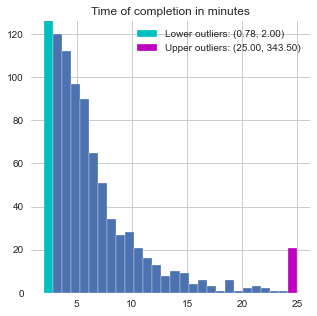

In [15]:
fig, ax = plt.subplots()

outlier_aware_hist(df['time_completion_min'], lower = 2, upper=25)
#plt.figtext(0.65,0.6, df['time_completion_min'].describe().to_string())

plt.title("Time of completion in minutes")
#ax.legend().set_visible(False)
fig.savefig('./plots/time_completion.png', format='png')
plt.show()

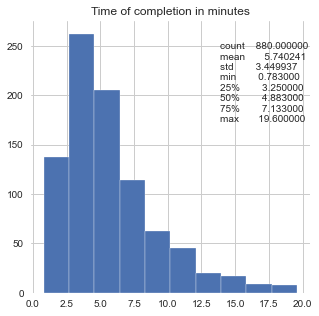

In [16]:
# df[df['time_completion_min']<=20]['time_completion_min'].plot.hist()
fig, ax = plt.subplots()
ax.hist(df[df['time_completion_min']<=20]['time_completion_min'], )
plt.figtext(0.65,0.6, df[df['time_completion_min']<=20]['time_completion_min'].describe().to_string())
plt.title("Time of completion in minutes")
fig.savefig('./plots/time_completion.svg', format='svg')
plt.show()

After looking at the data for the time completion, we decided to remove any subject that took less than 2 minutes to answer the survey. 

In [17]:
# Removing the subjects that answer in less or equal to 1 minutes to be sure we get subject that get focused. 
df[df['time_completion_min'] < 2]['time_completion_min'].count()


51

In [18]:
df[df['time_completion_min'] > 45]['time_completion_min'].count()

9

## Final dataset

In [19]:
df_raw = df[(df['time_completion_min'] > 2) & (df['time_completion_min'] <25)]
print('Size of the final filtered sample: {}'.format(df.shape[0]))

Size of the final filtered sample: 910


## Recoding

### Recode True - Fake news 

We recoded the different option of Fake news and True news and the answers to follow a easier format. Rather than having the answer being dependent to the question to know if it was a correct or no we did as following:

1. Recode the type of news as either `True` new or `Fake` news. 

1. In case of the subject thought a `True` news as `True`, the answer was recoded as `Right`

1. In case of the subject thought a `Fake` news was `Fake`, the answer was recoded as `Right`

1. In case of the subject thought a `True` news was `Fake`, the answer was recoded as `Wrong`

1. In case of the subject thought a `Fake` news was `True`, the answer was recoded as `Wrong`

In [20]:
# Recode the True - False and Fake news
df_raw = df_raw.rename(columns={'tysno_verdadera': 'True news', 'fysno_verdadera': "Fake news"})

# Recode the Si and No into Right and Wrong to avoid confusion
df_raw['True news'] = df_raw['True news'].replace({'sí': 'Right'})
df_raw['True news'] = df_raw['True news'].replace({'no': 'Wrong'})

df_raw['Fake news'] = df_raw['Fake news'].replace({'sí': 'Wrong'})
df_raw['Fake news'] = df_raw['Fake news'].replace({'no': 'Right'})

### Create count_error 

We created a variable called `count_error`. 
We simply check the number of time a subject did a mistake. 
* When the subject got `Right` to all answer, we coded `No error`
* If a subject did a mistake (regardless of considering a Fake news as True, or a True news as Fake), we recoded as `1 error`
* If a subject did 2 mistakes, we recoded as `2 errors`

In [21]:
# Get the number of error per profile
df_raw['count_error_int'] = (df_raw[['True news', 'Fake news']]=="Wrong").sum(axis="columns")
df_raw['count_error'] = df_raw['count_error_int']
df_raw['count_error'].value_counts()

df_raw = df_raw.astype({'count_error': 'category'})
# Transform the count errors into category type
df_raw.count_error.replace({0: 'No error', 1:'1 error', 2:'2 errors'}, inplace=True)



df_raw.count_error = pd.Categorical(df_raw.count_error, categories=['No error', '1 error', '2 errors'],ordered=True)

### Create the 4 categories variables

We created another way to group subjects. 
Here we followed the idea to divide in the 4 possible scenario

1. The subject got the `True` news `Right` and the `Fake` news `Right`: `TR-FR`

1. The subject got the `True` news `Right` and the `Fake` news `Wrong`: `TR-FW`

1. The subject got the `True` news `Wrong` and the `Fake` news `Right`: `TW-FR`

1. The subject got the `True` news `Wrong` and the `Fake` news `Wrong`: `TW-FW`

In [22]:
conditions = [
    (df_raw['True news'] == 'Right') & (df_raw['Fake news'] == 'Right'),
    (df_raw['True news'] == 'Right') & (df_raw['Fake news'] == 'Wrong'),
    (df_raw['True news'] == 'Wrong') & (df_raw['Fake news'] == 'Right'),
    (df_raw['True news'] == 'Wrong') & (df_raw['Fake news'] == 'Wrong'),
    ]

# create a list of the values we want to assign for each condition
values = ['TR-FR', 'TR-FW', 'TW-FR', 'TW-FW']
df_raw['cat_tf_rw'] = np.select(conditions, values)

In [23]:
df_raw['cat_tf_rw'].value_counts().to_frame()

,cat_tf_rw
TR-FR,360
TR-FW,210
TW-FR,178
TW-FW,92


### Create the 2 categories

Here, created a category with only the `Right` and `Wrong` distinction

In [24]:
df_raw['r_w'] = np.where(
    (df_raw['count_error_int'] > 0), 'W', 'R')

In [25]:
df_raw['r_w'].value_counts().to_frame()

,r_w
W,480
R,360


### Recoge gender

In [26]:
df_raw = df_raw.replace({"Femenino": "Female", 'Masculino': "Male"})

In [27]:
df_raw["Gender"] = df_raw['dm_genero']

In [28]:
c = df_raw["Gender"].value_counts(dropna=False)
p = df_raw["Gender"].value_counts(dropna=False, normalize=True)
p = p*100
pd.concat([c,p.round(0)], axis=1, keys=['counts', '%'])

,counts,%
Female,445,53.0
Male,395,47.0


### Recode religion

We decided to recode the religion into a dichotomic variable. The logic behind is that there were a lot of of `Católico` (n=512), `Ateo` (n=237) and `Agnóstico` (n=164), while other religions where low in number (n<10) (see the table under). 

In [29]:
df_raw['dm_religion'].value_counts(dropna=True)

Católico       390
Ateo           191
Agnóstico      142
Otro            20
-                8
Islámico         6
Protestante      3
Evangélico       3
Budista          3
Name: dm_religion, dtype: int64

In [30]:
# Recode religion into believers, atheist, agnostic

## Get the value of Otro in dm_pref_religion
df_raw['dm_pref_religion'] = df_raw.apply(lambda row: row['dm_religion'] if row['dm_religion'] != 'Otro' else row['dm_rel_otro'].strip().title(), axis=1)


## Recode the different entries into believers-atheist/agnostics
religion = ['Católico', 'Islámico', 'Evangélico', 'Protestante', 'Budista', 'Cristiano', 'Protestante', 
             'Musulmán', 'Grigoriano Apostolico', 'Soy Cristiana', 'Católica No Practicante', 'Testigo De Jehová', 
             'Católico Pero No Acudo A Misa', 'Soy Cristiano, Creo En Dios', 'Católico No Practicante',
             'Es Largo De Explicar , Es Una Iglesia Moderna', 'Creo En Las Ciencias Ocultas Y La Espiritualidad',
             'Creo En Dios A Través De Jesucristo',
             'Sincretismo Pragmático', 'Creo En Dios A Través De Jesucristo.', 'Ortodoxo']

no_religion = ['Agnóstico', 'Soy Agnóstico', 'Ateo', 'Ningún Punto Religioso..Creo En La Vida.', 'Ni Creo Ni Dejo De Creer' ]

df_raw['Religion'] = df_raw['dm_pref_religion'].replace(religion, 'Religious')
df_raw['Religion'] = df_raw['Religion'].replace(no_religion, 'No religious')
# Code as None if not within these two Religion
df_raw['Religion'] = np.where(df_raw['Religion'].isin(['Religious','No religious']), df_raw['Religion'], None)

After recoding, we obtained the following repartition between `Religious` and `No Religious`

In [31]:
c = df_raw["Religion"].value_counts(dropna=False)
p = df_raw["Religion"].value_counts(dropna=False, normalize=True)
p = p*100
pd.concat([c,p.round(0)], axis=1, keys=['counts', '%'])

,counts,%
Religious,420,50.0
No religious,334,40.0
NaN,86,10.0


### Recode politics

This variable has been recoded into `Izquierda`, `Centro`, `Derecha`, from the original question. 
* `Izquierda`: 'Izquierda', 'Centro izquierda'

* `Centro`: 'Centro'

* `Derecha`: 'Derecha', 'Centro derecha'

In [32]:
df_raw['dm_politica'].value_counts().to_frame()

,dm_politica
Izquierda,206
Centro izquierda,145
Centro,135
Centro derecha,98
Derecha,66
-,12


In [33]:
# aggregate politics preferences into bigger groups (izquierda, derecha, centro)
def aggregate_politics(val):
    if val in ['Izquierda', 'Centro izquierda']:
        return 'Left'
    elif val in ['Derecha', 'Centro derecha']:
        return 'Right'
    elif val == 'Centro':
        return "Centre"
    else:
        return None
df_raw['Political'] = df_raw['dm_politica'].apply(aggregate_politics)


After recoding, we obtained the following repartition

In [34]:
c = df_raw["Political"].value_counts(dropna=False)
p = df_raw["Political"].value_counts(dropna=False, normalize=True)
p = p*100
pd.concat([c,p.round(0)], axis=1, keys=['counts', '%'])

,counts,%
Left,351,42.0
NaN,190,23.0
Right,164,20.0
Centre,135,16.0


### Recode age

Age as been recoded to group in 3 categories:

* `<=18-34`: '< 18 años', '18-24 años', '25-34 años'

* `35-54`: '35-44 años', '45-54 años'

* `>55`: '55-65 años', '> 65 años'

In [35]:
df_raw['dm_edad'].value_counts(dropna=False)

45-54 años    235
35-44 años    187
55-65 años    164
25-34 años    132
18-24 años     69
> 65 años      53
Name: dm_edad, dtype: int64

In [36]:
# aggregate ages into bigger groups (18-34, 35-54, >54)
def aggregate_age(val):
    if val in ['< 18 años', '18-24 años', '25-34 años']:
        return '<=18-34'
    elif val in ['35-44 años', '45-54 años']:
        return '35-54'
    elif val in ['55-65 años', '> 65 años']:
        return '>55'
    elif val is None:
        return None
df_raw['Age'] = df_raw.dm_edad.apply(aggregate_age)

df_raw['Age'] = pd.Categorical(df_raw['Age'], categories=['<=18-34', '35-54', '>55'],ordered=True)

In [37]:
c = df_raw["Age"].value_counts(dropna=False )
p = df_raw["Age"].value_counts(dropna=False, normalize=True)
p = p*100
pd.concat([c,p.round(0)], axis=1, keys=['counts', '%'])

,counts,%
35-54,422,50.0
>55,217,26.0
<=18-34,201,24.0


### Recode education

Education has been recoded in two forms. One  is to group the subject into `Uni` vs `No Uni`. While the distinction makes sense regarding the data, it has been considered too *university-self-centerred*. Therefore we fall back on a three categories distinctions

* `up_to_secondaria`: 'Primaria', 'Secundaria', 'No tiene estudios en educación formal'

* `up_to_bac_3`: 'Formación Profesional', 'Bachillerato', 'Cou'

* `up_to_uni`: 'Master','Posgrado', 'Doctorado',  'Grado/Licenciatura'

In [38]:
df_raw['dm_educacion'].value_counts()

Grado/Licenciatura                       308
Formación Profesional                    230
Secundaria                               133
Master                                    86
Posgrado                                  36
Primaria                                  22
Doctorado                                 21
Otro                                       2
No tiene estudios en educación formal      1
Name: dm_educacion, dtype: int64

In [39]:
# Recode education
df_raw['dm_education'] = df_raw.apply(lambda row: row['dm_educacion'] if row['dm_educacion'] != 'Otro' else row['dm_edu_otro'].strip().title(), axis=1)


#education_recoded_values = ['Primaria', 'Secundaria', 'Formación Profesional', 'Grado/Licenciatura', 'Master', 'Posgrado', 'Doctorado' ]

# Code as None if not within the list of education level
#df_raw['recode_education'] = np.where(df_raw['dm_education'].isin(education_recoded_values), df_raw['dm_education'], None)


# Recode education into broader categories
uni = ['Posgrado', 'Doctorado', 'Master', 'Grado/Licenciatura' ]
non_uni = ['No tiene estudios en educación formal', 'Formación Profesional', 'Primaria', 'Secundaria', 'Cou', 'Bachillerato']




df_raw['Education'] = df_raw['dm_education'].replace(uni, 'University studies')
df_raw['Education'] = df_raw['Education'].replace(non_uni, 'No university studies')



# Alternative recoding
up_to_secondaria = ['Primaria', 'Secundaria', 'No tiene estudios en educación formal']
up_to_bac_3 = ['Formación Profesional', 'Bachillerato', 'Cou']
up_to_university_level = ['Master','Posgrado', 'Doctorado',  'Grado/Licenciatura']


# Code as None if not within these categories
df_raw['Education'] = np.where(df_raw['Education'].isin(['University studies', 'No university studies']), df_raw['Education'], None)
df_raw['Education'].value_counts()

df_raw['Education2'] = df_raw['dm_education'].replace(up_to_secondaria, 'Secondary')
df_raw['Education2'] = df_raw['Education2'].replace(up_to_bac_3, 'College')
df_raw['Education2'] = df_raw['Education2'].replace(up_to_university_level, 'University')

In [40]:
c = df_raw["Education2"].value_counts(dropna=False )
p = df_raw["Education2"].value_counts(dropna=False, normalize=True)
p = p*100
pd.concat([c,p.round(0)], axis=1, keys=['counts', '%'])

,counts,%
University,451,54.0
College,232,28.0
Secondary,156,19.0
NaN,1,0.0


### Recode Technological Level

In [41]:
df_raw = df_raw.replace({"Avanzada": "Advanced", 'Media': "Intermediate", "Básica": "Basic"})
df_raw['Technological'] = df_raw['dm_tecnologia']

In [42]:
c = df_raw["Technological"].value_counts(dropna=False )
p = df_raw["Technological"].value_counts(dropna=False, normalize=True)
p = p*100
pd.concat([c,p.round(0)], axis=1, keys=['counts', '%'])

,counts,%
Advanced,400,48.0
Intermediate,363,43.0
Basic,74,9.0
NaN,3,0.0


### Recode actions


In [43]:
# faf and taf are questions asked if the subject answer 'True' to the news in case of True and Fake news. 
# The faf will then for people who were wrong and the taf for people who were rignt
var_actions_f = ['faf_compartira_familia_amigos', 'faf_publicara_redes', 'faf_consultara_fuentes', 'faf_aplicara_aprendido', 'faf_no_accion']
var_actions_t = ['taf_compartira_familia_amigos', 'taf_publicara_redes', 'taf_consultara_fuentes', 'taf_aplicara_aprendido', 'taf_no_accion']
var_actions = var_actions_f + var_actions_t
df_raw.loc[:, var_actions] = df_raw.loc[:, var_actions].replace({'checked': True, 'unchecked': False})
df_raw.loc[:, var_actions]

,faf_compartira_familia_amigos,faf_publicara_redes,faf_consultara_fuentes,faf_aplicara_aprendido,faf_no_accion,taf_compartira_familia_amigos,taf_publicara_redes,taf_consultara_fuentes,taf_aplicara_aprendido,taf_no_accion
0,False,False,False,False,True,False,False,False,False,True
1,True,False,False,False,False,False,False,False,False,True
3,False,False,False,False,True,False,False,False,True,False
4,False,False,True,False,False,False,False,True,False,False
5,False,False,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...
1058,False,False,False,False,True,True,False,False,False,False
1059,False,False,False,False,True,True,False,False,False,False
1060,False,False,True,False,False,False,False,True,False,False
1061,False,True,False,False,False,False,False,False,False,True


There is an issue with some subjects answering the no_action while answering other types of action at the same time


In [44]:
# There is an issue with some subjects answering the no_action while answering other types of action at the same time
df_raw['total_checked_f'] = df_raw.loc[:, var_actions_f].isin([True]).sum(axis=1)
df_raw['total_checked_t'] = df_raw.loc[:, var_actions_t].isin([True]).sum(axis=1)

In [45]:
# Drop the subjects when conflicting answer in case of analysing actions. 
df_raw[(df_raw['total_checked_f'] > 1) & (df_raw['faf_no_accion'] == True)][['total_checked_f', *var_actions_f]]

,total_checked_f,faf_compartira_familia_amigos,faf_publicara_redes,faf_consultara_fuentes,faf_aplicara_aprendido,faf_no_accion
92,2,False,False,False,True,True
94,2,False,False,True,False,True
259,2,False,False,True,False,True
344,2,False,False,True,False,True
534,2,False,False,True,False,True
588,2,False,False,True,False,True
670,2,False,False,True,False,True
673,2,False,False,True,False,True
779,2,False,False,True,False,True
808,2,False,False,True,False,True


In [46]:
# Drop the subjects when conflicting answer in case of analysing actions. 

for x in var_actions_f:
    df_raw.loc[(df_raw['total_checked_f'] > 1) & (df_raw['faf_no_accion'] == True), x] = np.NaN

In [47]:
df_raw[(df_raw['total_checked_t'] > 1) & (df_raw['taf_no_accion'] == True)][['total_checked_t', *var_actions_t]]

,total_checked_t,taf_compartira_familia_amigos,taf_publicara_redes,taf_consultara_fuentes,taf_aplicara_aprendido,taf_no_accion
79,2,False,False,True,False,True
94,2,False,False,True,False,True
238,2,False,False,False,True,True
327,3,False,False,True,True,True
332,2,False,False,False,True,True
367,2,False,False,False,True,True
394,2,True,False,False,False,True
450,3,False,False,True,True,True
508,2,False,False,True,False,True
516,2,False,False,False,True,True


In [48]:
# Drop the subjects when conflicting answer in case of analysing actions. 
for x in var_actions_t:
    df_raw.loc[(df_raw['total_checked_t'] > 1) & (df_raw['taf_no_accion'] == True), x] = np.NaN

### Recode justifications

In [49]:
# Rename two columns for tys that are different than the column from fys and create issue later in analysis
df_raw = df_raw.rename(columns={'tys_medio_comunicacion_conocido': 'tys_medio_conocido', 'tys_medio_comunicacion_fiable': 'tys_medio_fiable'})

In [50]:
var_justification_fake = ['tno_aclaracion_desmintiendo',
'tno_medio_desconocido',
'tno_medio_poco_fiable',
'tno_fuentes_desconocidas',
'tno_fuentes_no_confiables',
'tno_sin_fuentes',
'tno_abordaje_no_serio',
'tno_no_coherente',
'tno_titulo_sensacionalista',
'tno_imagen_sensacionalista',
'tno_no_concuerda_creencias',
'tno_no_alineado_ideologia',
'tno_otro','fno_aclaracion_desmintiendo',
'fno_medio_desconocido',
'fno_medio_poco_fiable',
'fno_fuentes_desconocidas',
'fno_fuentes_no_confiables',
'fno_sin_fuentes',
'fno_abordaje_no_serio',
'fno_no_coherente',
'fno_titulo_sensacionalista',
'fno_imagen_sensacionalista',
'fno_no_concuerda_creencias',
'fno_no_alineado_ideologia',
'fno_otro']
var_justification_true = ['fys_recuerda_leida',
'fys_medio_conocido',
'fys_medio_fiable',
'fys_fuentes_conocidas',
'fys_fuentes_confiables',
'fys_abordaje_serio',
'fys_coherente',
'fys_concuerda_creencias',
'fys_alineado_ideologia',
'fys_otro',
'tys_recuerda_leida',
'tys_medio_conocido',
'tys_medio_fiable',
'tys_fuentes_conocidas',
'tys_fuentes_confiables',
'tys_abordaje_serio',
'tys_coherente',
'tys_concuerda_creencias',
'tys_alineado_ideologia',
'tys_otro']

var_justifications = var_justification_true + var_justification_fake
df_raw.loc[:, var_justifications] = df_raw.loc[:, var_justifications].replace({'checked': True, 'unchecked': False, 'undisplayed': np.NaN})

# Dataset from news perspective

## Melt the sampled dataset

In [58]:
# Transform the main df into df by news 
df_news = df_raw.melt(id_vars=[*[i for i in df_raw.columns if i not in ['fake_news', 'true_news']]])

df_news = df_news.rename(columns={'variable': 'type_news', 'value': 'news_title'})


In [59]:
## Get the answer for each answer
df_news['answer'] = np.where(df_news['type_news'] == 'fake_news', df_news['Fake news'],
         (np.where(df_news['type_news'] == 'true_news', df_news['True news'], np.NaN)))

## Drop Fake news and True News

df_news = df_news.drop(columns=['first_true', 'reread_fake', 'Fake news', 'True news'])

## Add the justifications

In [60]:
# In case the subject thinks it is a Fake News (regardless of the news)
var_justification_true_wrong = ['tno_aclaracion_desmintiendo',
'tno_medio_desconocido',
'tno_medio_poco_fiable',
'tno_fuentes_desconocidas',
'tno_fuentes_no_confiables',
'tno_sin_fuentes',
'tno_abordaje_no_serio',
'tno_no_coherente',
'tno_titulo_sensacionalista',
'tno_imagen_sensacionalista',
'tno_no_concuerda_creencias',
'tno_no_alineado_ideologia',
'tno_otro']

var_justification_fake_right = ['fno_aclaracion_desmintiendo',
'fno_medio_desconocido',
'fno_medio_poco_fiable',
'fno_fuentes_desconocidas',
'fno_fuentes_no_confiables',
'fno_sin_fuentes',
'fno_abordaje_no_serio',
'fno_no_coherente',
'fno_titulo_sensacionalista',
'fno_imagen_sensacionalista',
'fno_no_concuerda_creencias',
'fno_no_alineado_ideologia',
'fno_otro']

## Creating it for the fake news
df_fake = df_news[df_news['type_news'] == 'fake_news'][[ 'news_title', *var_justification_fake_right]]
df_fake = df_fake.replace({True: 1, False: 0})
df_fake = df_fake.groupby('news_title').agg('mean')
df_fake.columns = ['justification_avg_' + '_'.join(i.split('_')[1:]) for i in df_fake.columns]

## Creating for the true news
df_true = df_news[df_news['type_news'] == 'true_news'][['news_title', *var_justification_true_wrong]]
df_true = df_true.replace({True: 1, False: 0})
df_true = df_true.groupby('news_title').agg('mean')
df_true.columns = ['justification_avg_' + '_'.join(i.split('_')[1:]) for i in df_true.columns]

## Append the two dataframe
df_avg_justification_fake = df_fake
df_avg_justification_fake = df_avg_justification_fake.append(df_true)
df_avg_justification_fake = df_avg_justification_fake.reset_index().rename(columns={'index': 'news_title'})

In [61]:
# In cases the subject is right for true news and wrong for fake news
var_justification_fake_wrong = ['fys_recuerda_leida',
'fys_medio_conocido',
'fys_medio_fiable',
'fys_fuentes_conocidas',
'fys_fuentes_confiables',
'fys_abordaje_serio',
'fys_coherente',
'fys_concuerda_creencias',
'fys_alineado_ideologia',
'fys_otro']

var_justification_true_right = ['tys_recuerda_leida',
'tys_medio_conocido',
'tys_medio_fiable',
'tys_fuentes_conocidas',
'tys_fuentes_confiables',
'tys_abordaje_serio',
'tys_coherente',
'tys_concuerda_creencias',
'tys_alineado_ideologia',
'tys_otro']

## Creating it for the fake news
df_fake = df_news[df_news['type_news'] == 'fake_news'][[ 'news_title', *var_justification_fake_wrong]]
df_fake = df_fake.replace({True: 1, False: 0})
df_fake = df_fake.groupby('news_title').agg('mean')
df_fake.columns = ['justification_avg_' + '_'.join(i.split('_')[1:]) for i in df_fake.columns]

## Creating for the true news
df_true = df_news[df_news['type_news'] == 'true_news'][['news_title', *var_justification_true_right]]
df_true = df_true.replace({True: 1, False: 0})
df_true = df_true.groupby('news_title').agg('mean')
df_true.columns = ['justification_avg_' + '_'.join(i.split('_')[1:]) for i in df_true.columns]

## Append the two dataframes
df_avg_justification_true = df_fake
df_avg_justification_true = df_avg_justification_true.append(df_true)
df_avg_justification_true = df_avg_justification_true.reset_index().rename(columns={'index': 'news_title'})

# Merging all the possibilities
df_avg_justification = df_avg_justification_fake.merge(df_avg_justification_true, on='news_title')

## Add the different actions

In [62]:
var_actions_f = ['faf_compartira_familia_amigos', 'faf_publicara_redes', 'faf_consultara_fuentes', 'faf_aplicara_aprendido', 'faf_no_accion']
var_actions_t = ['taf_compartira_familia_amigos', 'taf_publicara_redes', 'taf_consultara_fuentes', 'taf_aplicara_aprendido', 'taf_no_accion']


## Creating it for the fake news
df_fake = df_news[df_news['type_news'] == 'fake_news'][[ 'news_title', *var_actions_f]]
df_fake = df_fake.replace({True: 1, False: 0})
df_fake = df_fake.groupby('news_title').agg('mean')
df_fake.columns = ['action_avg_' + '_'.join(i.split('_')[1:]) for i in df_fake.columns]

## Creating for the true news
df_true = df_news[df_news['type_news'] == 'true_news'][['news_title', *var_actions_t]]
df_true = df_true.replace({True: 1, False: 0})
df_true = df_true.groupby('news_title').agg('mean')
df_true.columns = ['action_avg_' + '_'.join(i.split('_')[1:]) for i in df_true.columns]

## Append the two dataframe
df_avg_action = df_fake
df_avg_action = df_avg_action.append(df_true)
df_avg_action = df_avg_action.reset_index().rename(columns={'index': 'news_title'})

## Add all the information

In [63]:
#### Removing all the uneeded columns 
df_news_details = df_news[['news_title', 'type_news']]

# Drop duplicated rows as from the df_news
df_news_details = df_news_details.drop_duplicates()


#### Merge with the topics
df_news_details = df_news_details.merge(df_topic, on='news_title')


#### Merge the justification
df_news_details = df_news_details.merge(df_avg_justification, on='news_title')


#### Merge the actions
df_news_details = df_news_details.merge(df_avg_action, on='news_title')


### Merge the resulting df with the info by news

df_news = df_news.merge(df_news_details, on='news_title', how='left')


#### Drop the type_news_y and rename type_news_x into type_news (they are identical after checking)
df_news = df_news.drop(columns=['type_news_y'])
df_news = df_news.rename(columns={'type_news_x': 'type_news'})

In [64]:
## Cleaning the columns about actions to get all under the same title and remove the uneeded columns
for col in ['compartira_familia_amigos', 'publicara_redes', 'consultara_fuentes', 'aplicara_aprendido', 'no_accion']:
    wrong_prefix = 'faf_'
    right_prefix = 'taf_'
    right_condition = ((df_news['type_news'] == 'true_news') & (df_news['answer'] == 'Right'))
    wrong_condition = ((df_news['type_news'] == 'fake_news') & (df_news['answer'] == 'Wrong'))
    df_news[col] = np.where(right_condition, 
                            df_news['{}{}'.format(right_prefix, col)],
                            (np.where(wrong_condition, 
                                      df_news['{}{}'.format(wrong_prefix, col)], None)))

                                      
## Remove all the unneeded columns
df_news = df_news.drop(columns=[ 'taf_compartira_familia_amigos', 
                                'taf_publicara_redes', 
                                'taf_consultara_fuentes', 
                                'taf_aplicara_aprendido', 
                                'taf_no_accion', 'faf_compartira_familia_amigos', 'faf_publicara_redes', 'faf_consultara_fuentes', 'faf_aplicara_aprendido', 'faf_no_accion'])

## Rename the columns in English
to_rename = {'compartira_familia_amigos': 'share_friends_and_family',
             'publicara_redes': 'share_online',
             'consultara_fuentes': 'verify_source',
             'aplicara_aprendido': "apply_learning",
             'no_accion': 'no_action'}
df_news = df_news.rename(columns=to_rename)

In [65]:
## Cleaning the columns about justification to get all under the same title and remove the uneeded columns

var_justification_fake = ['tno_aclaracion_desmintiendo',
                          'tno_medio_desconocido',
                          'tno_medio_poco_fiable',
                          'tno_fuentes_desconocidas',
                          'tno_fuentes_no_confiables',
                          'tno_sin_fuentes',
                          'tno_abordaje_no_serio',
                          'tno_no_coherente',
                          'tno_titulo_sensacionalista',
                          'tno_imagen_sensacionalista',
                          'tno_no_concuerda_creencias',
                          'tno_no_alineado_ideologia',
                          'tno_otro',
                          'fno_aclaracion_desmintiendo',
                          'fno_medio_desconocido',
                          'fno_medio_poco_fiable',
                          'fno_fuentes_desconocidas',
                          'fno_fuentes_no_confiables',
                          'fno_sin_fuentes',
                          'fno_abordaje_no_serio',
                          'fno_no_coherente',
                          'fno_titulo_sensacionalista',
                          'fno_imagen_sensacionalista',
                          'fno_no_concuerda_creencias',
                          'fno_no_alineado_ideologia',
                          'fno_otro']

var_justification_true = ['fys_recuerda_leida',
                          'fys_medio_conocido',
                          'fys_medio_fiable',
                          'fys_fuentes_conocidas',
                          'fys_fuentes_confiables',
                          'fys_abordaje_serio',
                          'fys_coherente',
                          'fys_concuerda_creencias',
                          'fys_alineado_ideologia',
                          'fys_otro',
                          'tys_recuerda_leida',
                          'tys_medio_conocido',
                          'tys_medio_fiable',
                          'tys_fuentes_conocidas',
                          'tys_fuentes_confiables',
                          'tys_abordaje_serio',
                          'tys_coherente',
                          'tys_concuerda_creencias',
                          'tys_alineado_ideologia',
                          'tys_otro']

var_just_fake = ['aclaracion_desmintiendo',
                 'medio_desconocido',
                 'medio_poco_fiable',
                 'fuentes_desconocidas',
                 'fuentes_no_confiables',
                 'sin_fuentes',
                 'abordaje_no_serio',
                 'no_coherente',
                 'titulo_sensacionalista',
                 'imagen_sensacionalista',
                 'no_concuerda_creencias',
                 'no_alineado_ideologia',
                 'otro']

var_just_true = ['recuerda_leida',
                 'medio_conocido',
                 'medio_fiable',
                 'fuentes_conocidas',
                 'fuentes_confiables',
                 'abordaje_serio',
                 'coherente',
                 'concuerda_creencias',
                 'alineado_ideologia',
                 'otro']

# TNO: True news and Wrong answer
# FNO: Fake news and Right answer
for col in var_just_fake:
    wrong_prefix = 'fno_'
    right_prefix = 'tno_'
    right_condition = ((df_news['type_news'] == 'fake_news') & (df_news['answer'] == 'Right'))
    wrong_condition = ((df_news['type_news'] == 'true_news') & (df_news['answer'] == 'Wrong'))
    df_news[col] = np.where(right_condition, 
                            df_news['{}{}'.format(right_prefix, col)],
                            (np.where(wrong_condition, 
                                      df_news['{}{}'.format(wrong_prefix, col)], None)))

                                      
## Remove all the unneeded columns
df_news = df_news.drop(columns=var_justification_fake)

# FYS: Fake news and Wrong answer
# TYS: True news and Right answer 
for col in var_just_true:
    wrong_prefix = 'fys_'
    right_prefix = 'tys_'
    right_condition = ((df_news['type_news'] == 'true_news') & (df_news['answer'] == 'Right'))
    wrong_condition = ((df_news['type_news'] == 'fake_news') & (df_news['answer'] == 'Wrong'))
    df_news[col] = np.where(right_condition, 
                            df_news['{}{}'.format(right_prefix, col)],
                            (np.where(wrong_condition, 
                                      df_news['{}{}'.format(wrong_prefix, col)], None)))

## Remove all the unneeded columns
df_news = df_news.drop(columns=var_justification_true)

## Rename the different justifications in English
var_trans_fake = {'aclaracion_desmintiendo': "Previously_read_debunked",
                 'medio_desconocido': "Source_unknown",
                 'medio_poco_fiable': "Media_unreliable",
                 'fuentes_desconocidas': "Cited_sources_unknown",
                 'fuentes_no_confiables': "Cited_sources_unreliable",
                 'sin_fuentes': "Without_sources",
                 'abordaje_no_serio': "Unprofessional_style",
                 'no_coherente': "No_coherent",
                 'titulo_sensacionalista': "Headline_sensationalist",
                 'imagen_sensacionalista': "Image_sensationalist",
                 'no_concuerda_creencias':"Different_belief",
                 'no_alineado_ideologia':"Different_ideology",
                 'otro': "Other"}

var_trans_true = {'recuerda_leida': "Previously_read_the_information",
                 'medio_conocido': "Known_media",
                 'medio_fiable': "Reliable_media",
                 'fuentes_conocidas':"Source_known",
                 'fuentes_confiables':"Source_Reliable",
                 'abordaje_serio': "Professional_style",
                 'coherente': "Coherent",
                 'concuerda_creencias':"Same_belief",
                 'alineado_ideologia':"Same_ideology",
                 'otro': "Other"}

df_news = df_news.rename(columns=var_trans_fake)
df_news = df_news.rename(columns=var_trans_true)

# Records the different datasets

In [66]:
# Save the dataset into a clean csv file for further analysis
df.to_csv('{}{}'.format(data_folder, dataset_clean_filename),  index = False)

# Save the df_news_information
#df_news_details.to_csv('{}{}'.format(data_folder, dataset_news_filename), index=False)

# Save the df_news_full
df_news.to_csv('{}{}'.format(data_folder, dataset_news_full_filename), index=False)



## Save the dataset to be updated containing only the info for the analysis


# References

## Packages

 * mord: [https://github.com/fabianp/mord](https://github.com/fabianp/mord)
     >Pedregosa, Fabian, Francis Bach, and Alexandre Gramfort. "On the consistency of ordinal regression methods." The Journal of Machine Learning Research 18.1 (2017) JMLR.
 * pingouin: [https://pingouin-stats.org/](https://pingouin-stats.org/)
     > Vallat, R. (2018). Pingouin: statistics in Python. Journal of Open Source Software, 3(31), 1026, https://doi.org/10.21105/joss.01026
 * statsmodels: [https://www.statsmodels.org](https://www.statsmodels.org)
    > @inproceedings{seabold2010statsmodels,title={statsmodels: Econometric and statistical modeling with python}, author={Seabold, Skipper and Perktold, Josef}, booktitle={9th Python in Science Conference},year={2010},}
 * scipy: [https://www.scipy.org](https://www.scipy.org)
     > @ARTICLE{2020SciPy-NMeth, author  = {Virtanen, Pauli and Gommers, Ralf and Oliphant, Travis E. and Haberland, Matt and Reddy, Tyler and Cournapeau, David and Burovski, Evgeni and Peterson, Pearu and Weckesser, Warren and Bright, Jonathan and {van der Walt}, St{\'e}fan J. and Brett, Matthew and Wilson, Joshua and Millman, K. Jarrod and Mayorov, Nikolay and Nelson, Andrew R. J. and Jones, Eric and Kern, Robert and Larson, Eric and Carey, C J and Polat, {\.I}lhan and Feng, Yu and Moore, Eric W. and {VanderPlas}, Jake and Laxalde, Denis and Perktold, Josef and Cimrman, Robert and Henriksen, Ian and Quintero, E. A. and Harris, Charles R. and Archibald, Anne M. and Ribeiro, Ant{\^o}nio H. and Pedregosa, Fabian and {van Mulbregt}, Paul and {SciPy 1.0 Contributors}},title   = {{{SciPy} 1.0: Fundamental Algorithms for Scientific Computing in Python}}, journal = {Nature Methods}, year    = {2020}, volume  = {17}, pages   = {261--272}, adsurl  = {https://rdcu.be/b08Wh}, doi     = {10.1038/s41592-019-0686-2},}
 * scikit-learn: [https://scikit-learn.org](https://scikit-learn.org)
     > Fabian Pedregosa, Gaël Varoquaux, Alexandre Gramfort, Vincent Michel, Bertrand Thirion, Olivier Grisel, Mathieu Blondel, Peter Prettenhofer, Ron Weiss, Vincent Dubourg, Jake Vanderplas, Alexandre Passos, David Cournapeau, Matthieu Brucher, Matthieu Perrot, Édouard Duchesnay. Scikit-learn: Machine Learning in Python, Journal of Machine Learning Research, 12, 2825-2830 (2011) (publisher link)
     
 * pymer4: [https://eshinjolly.com/pymer4/]
     > Jolly, (2018). Pymer4: Connecting R and Python for Linear Mixed Modeling. Journal of Open Source Software, 3(31), 862, https://doi.org/10.21105/joss.00862

## Articles

*   Bürkner, P.-C., & Vuorre, M. (2019). Ordinal Regression Models in Psychology: A Tutorial. Advances in Methods and Practices in Psychological Science, 77–101. https://doi.org/10.1177/2515245918823199